In [78]:
# pyg-team
# from: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py

In [79]:
import os.path as ospath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn import Linear, LeakyReLU
from sklearn.metrics import roc_auc_score
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data, Dataset
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## load data

In [80]:
prefix1 = 'dataset1'
prefix2 = 'dataset2'
prefix3 = 'dataset3'

df_train1 = pd.read_csv(f'{prefix1}/train.csv')
df_test1 = pd.read_csv(f'{prefix1}/test.csv')
df_content1 = pd.read_csv(f'{prefix1}/content.csv', sep='\t', header=None, index_col=0)

df_train2 = pd.read_csv(f'{prefix2}/train.csv')
df_test2 = pd.read_csv(f'{prefix2}/test.csv')
df_content2 = pd.read_csv(f'{prefix2}/content.csv', sep='\t', header=None, index_col=0)

df_train3 = pd.read_csv(f'{prefix3}/train.csv')
df_test3 = pd.read_csv(f'{prefix3}/test.csv')
df_content3 = pd.read_csv(f'{prefix3}/content.csv', sep='\t', header=None, index_col=0)

df_content1 = df_content1.sort_index()
df_content2 = df_content2.sort_index()
df_content3 = df_content3.sort_index()

In [81]:
def print_shape(df_train, df_test, df_content):
    print(f"{'Train Shape':<15}: {df_train.shape}")
    print(f"{'Test Shape':<15}: {df_test.shape}")
    print(f"{'Content Shape':<15}: {df_content.shape}")

print_shape(df_train1, df_test1, df_content1)

Train Shape    : (8686, 4)
Test Shape     : (2172, 3)
Content Shape  : (2708, 1433)


In [82]:
df_train1

,id,to,from,label
0,E10311,2399,2339,0
1,E10255,2397,1144,1
2,E10667,854,1726,0
3,E9395,872,702,0
4,E5926,2450,1312,1
...,...,...,...,...
8681,E1171,1643,1383,0
8682,E4741,1879,1443,1
8683,E9256,171,1711,1
8684,E4322,633,2440,1


In [83]:

def df2data(df_train, df_test, df_content):
    X = torch.tensor(df_content.values, dtype=torch.float32)
    mask_pos = (df_train['label'] == 1)
    train_edge_index = torch.tensor(df_train.loc[mask_pos, ['from', 'to']].values).T
    # train_edge_label_index = torch.tensor(df_train[['from', 'to']].values).T
    train_edge_label_index = torch.tensor(df_train.loc[mask_pos, ['from', 'to']].values).T
    train_edge_label = torch.ones(size=(train_edge_index.shape[1], ), dtype=torch.float32)

    test_edge_label_index = torch.tensor(df_test.iloc[:, 1:3].values).T

    train_data = Data(x=X, edge_index=train_edge_index, edge_label_index=train_edge_label_index, edge_label=train_edge_label)
    test_data = Data(x=X, edge_index=train_edge_index, edge_label_index=test_edge_label_index)
    return train_data, test_data

train_data1, test_data1 = df2data(df_train1, df_test1, df_content1)
train_data2, test_data2 = df2data(df_train2, df_test2, df_content2)
train_data3, test_data3 = df2data(df_train3, df_test3, df_content3)

In [84]:
[train_data1, test_data1]

[Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 4324], edge_label=[4324]),
 Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 2172])]

## train val split

In [85]:
# def train_val_split(train_data, val_size=0.05):
#     ind = np.arange(train_data.edge_label_index.shape[1])
#     np.random.shuffle(ind)
#     val_len = int(train_data.edge_label_index.shape[1] * val_size)

#     val_ind = ind[:val_len]
#     train_ind = ind[val_len:]

#     x = train_data.x
#     edge_index = train_data.edge_index.T
#     edge_label_index = train_data.edge_label_index.T
#     edge_label = train_data.edge_label

#     val_edge_label_index = edge_label_index[val_ind]
#     val_edge_label = edge_label[val_ind]

#     # n_val_data = Data(
#     #     x=x,
#     #     edge_index=,
#     #     edge_label_index=.T,
#     #     edge_label=)
    
#     # train_edge_index = np.setdiff1d(edge_index, val_edge_label_index).reshape(-1, 2)
#     print(train_edge_index.shape)
#     n_train_data = Data(
#         x=train_data.x, 
#         edge_index=train_edge_index.T,
#         edge_label_index=edge_label_index[train_ind].T,
#         edge_label=edge_label[train_ind])


# train_val_split(train_data1)
    

In [86]:
df_train1['label'].value_counts()

0    4362
1    4324
Name: label, dtype: int64

In [87]:
# def train_val_split(train_data):
#     ran_link_split = T.RandomLinkSplit(num_val=0.05, num_test=0,
#                                     is_undirected=True,
#                                     add_negative_train_samples=False)
#     print(train_data.edge_index.shape)
#     print(train_data.y.shape)
#     n_train_data = Data(x=train_data.x, edge_label=train_data.y, edge_index=train_data.edge_index)
#     n_train_data, n_val_data, n_test_data = ran_link_split(n_train_data)
#     print(n_train_data)
#     print(n_val_data)
#     print(n_test_data)
    
# train_val_split(train_data1)

## preprocessing

In [88]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device)
])
train_data1, test_data1 = transform(train_data1), transform(test_data1)
train_data2, test_data2 = transform(train_data2), transform(test_data2)
train_data3, test_data3 = transform(train_data3), transform(test_data3)

In [89]:
train_data1

Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 4324], edge_label=[4324])

In [90]:
train_data1.edge_index

tensor([[1144, 1312, 2472,  ..., 1711, 2440, 1222],
        [2397, 2450, 1808,  ...,  171,  633,  122]], device='cuda:0')

In [91]:
train_data1.edge_label_index

tensor([[1144, 1312, 2472,  ..., 1711, 2440, 1222],
        [2397, 2450, 1808,  ...,  171,  633,  122]], device='cuda:0')

In [92]:
[train_data1, test_data1]

[Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 4324], edge_label=[4324]),
 Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 2172])]

In [93]:
negative_sampling(train_data1.edge_index)

tensor([[1959, 2105,  111,  ...,  575, 2114, 1277],
        [ 871, 2560,  889,  ..., 2678, 2278, 1939]], device='cuda:0')

In [94]:
train_data1.edge_index

tensor([[1144, 1312, 2472,  ..., 1711, 2440, 1222],
        [2397, 2450, 1808,  ...,  171,  633,  122]], device='cuda:0')

In [95]:
((train_data1.edge_index[0] == 2399) & (train_data1.edge_index[1] == 2339)).sum()

tensor(0, device='cuda:0')

In [111]:
class Net(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        c1_channels = 128
        c2_channels = 128
        lin1_channels = 128
        lin2_channels = 64
        self.conv1 = GCNConv(in_channels,  c1_channels)
        self.conv2 = GCNConv(c1_channels, c2_channels)
        self.leaky_relu = LeakyReLU()
        self.lin1 = Linear(c2_channels, lin1_channels)
        self.lin2 = Linear(lin1_channels, lin2_channels)

    def encode(self, x, edge_index):
        h = self.leaky_relu(self.conv1(x, edge_index))
        h = self.conv2(h, edge_index)
        # h = self.lin1(h).relu()
        # h = self.lin2(h)
        return h

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

def fit(train_data, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)
    # edge_label_index = train_data.edge_label_index
    # edge_label = train_data.edge_label

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()

# @torch.no_grad()
# def test(data):
#     model.eval()
#     z = model.encode(data.x, data.edge_index)
#     out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
#     return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

def train_loop(train_data, lr):
    model = Net(train_data.x.shape[1]).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    ls_loss = []
    best_loss = 1e10
    best_model = model
    for epoch in range(1, 10000):
        loss = fit(train_data, model, optimizer, criterion)
        if loss < best_loss:
            best_loss = loss
            best_model = model
        print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}')
        ls_loss.append(loss)
    print('best_loss: ', round(best_loss, 5))
    return best_model, ls_loss

In [112]:
def plot_loss(ls_loss):
    fig, ax = plt.subplots(figsize=(10, 6))
    epoch = list(range(1, len(ls_loss)+1))
    ax.plot(epoch, ls_loss)

In [113]:
lr = 0.001
model1, ls_loss1 = train_loop(train_data1, lr)

Epoch: 0001, Loss: 0.6921
Epoch: 0002, Loss: 0.6912
Epoch: 0003, Loss: 0.6896
Epoch: 0004, Loss: 0.6874
Epoch: 0005, Loss: 0.6844
Epoch: 0006, Loss: 0.6806
Epoch: 0007, Loss: 0.6760
Epoch: 0008, Loss: 0.6715
Epoch: 0009, Loss: 0.6676
Epoch: 0010, Loss: 0.6656
Epoch: 0011, Loss: 0.6707
Epoch: 0012, Loss: 0.6716
Epoch: 0013, Loss: 0.6677
Epoch: 0014, Loss: 0.6674
Epoch: 0015, Loss: 0.6642
Epoch: 0016, Loss: 0.6632
Epoch: 0017, Loss: 0.6607
Epoch: 0018, Loss: 0.6623
Epoch: 0019, Loss: 0.6623
Epoch: 0020, Loss: 0.6604
Epoch: 0021, Loss: 0.6615
Epoch: 0022, Loss: 0.6598
Epoch: 0023, Loss: 0.6592
Epoch: 0024, Loss: 0.6573
Epoch: 0025, Loss: 0.6560
Epoch: 0026, Loss: 0.6552
Epoch: 0027, Loss: 0.6532
Epoch: 0028, Loss: 0.6531
Epoch: 0029, Loss: 0.6537
Epoch: 0030, Loss: 0.6518
Epoch: 0031, Loss: 0.6540
Epoch: 0032, Loss: 0.6481
Epoch: 0033, Loss: 0.6498
Epoch: 0034, Loss: 0.6457
Epoch: 0035, Loss: 0.6455
Epoch: 0036, Loss: 0.6451
Epoch: 0037, Loss: 0.6474
Epoch: 0038, Loss: 0.6446
Epoch: 0039,

In [114]:
lr = 0.0005
model2, ls_loss2 = train_loop(train_data2, lr)

Epoch: 0001, Loss: 0.6929
Epoch: 0002, Loss: 0.6928
Epoch: 0003, Loss: 0.6925
Epoch: 0004, Loss: 0.6922
Epoch: 0005, Loss: 0.6917
Epoch: 0006, Loss: 0.6911
Epoch: 0007, Loss: 0.6903
Epoch: 0008, Loss: 0.6893
Epoch: 0009, Loss: 0.6882
Epoch: 0010, Loss: 0.6868
Epoch: 0011, Loss: 0.6852
Epoch: 0012, Loss: 0.6834
Epoch: 0013, Loss: 0.6814
Epoch: 0014, Loss: 0.6796
Epoch: 0015, Loss: 0.6778
Epoch: 0016, Loss: 0.6758
Epoch: 0017, Loss: 0.6741
Epoch: 0018, Loss: 0.6730
Epoch: 0019, Loss: 0.6728
Epoch: 0020, Loss: 0.6710
Epoch: 0021, Loss: 0.6692
Epoch: 0022, Loss: 0.6705
Epoch: 0023, Loss: 0.6700
Epoch: 0024, Loss: 0.6680
Epoch: 0025, Loss: 0.6664
Epoch: 0026, Loss: 0.6647
Epoch: 0027, Loss: 0.6660
Epoch: 0028, Loss: 0.6628
Epoch: 0029, Loss: 0.6610
Epoch: 0030, Loss: 0.6604
Epoch: 0031, Loss: 0.6583
Epoch: 0032, Loss: 0.6566
Epoch: 0033, Loss: 0.6561
Epoch: 0034, Loss: 0.6556
Epoch: 0035, Loss: 0.6548
Epoch: 0036, Loss: 0.6519
Epoch: 0037, Loss: 0.6499
Epoch: 0038, Loss: 0.6484
Epoch: 0039,

In [115]:
lr = 0.005
model3, ls_loss3 = train_loop(train_data3, lr)

Epoch: 0001, Loss: 0.6928
Epoch: 0002, Loss: 0.6740
Epoch: 0003, Loss: 0.6463
Epoch: 0004, Loss: 0.7003
Epoch: 0005, Loss: 0.6504
Epoch: 0006, Loss: 0.6490
Epoch: 0007, Loss: 0.6613
Epoch: 0008, Loss: 0.6656
Epoch: 0009, Loss: 0.6640
Epoch: 0010, Loss: 0.6570
Epoch: 0011, Loss: 0.6449
Epoch: 0012, Loss: 0.6380
Epoch: 0013, Loss: 0.6394
Epoch: 0014, Loss: 0.6472
Epoch: 0015, Loss: 0.6485
Epoch: 0016, Loss: 0.6402
Epoch: 0017, Loss: 0.6375
Epoch: 0018, Loss: 0.6365
Epoch: 0019, Loss: 0.6391
Epoch: 0020, Loss: 0.6381
Epoch: 0021, Loss: 0.6315
Epoch: 0022, Loss: 0.6293
Epoch: 0023, Loss: 0.6288
Epoch: 0024, Loss: 0.6275
Epoch: 0025, Loss: 0.6267
Epoch: 0026, Loss: 0.6195
Epoch: 0027, Loss: 0.6203
Epoch: 0028, Loss: 0.6180
Epoch: 0029, Loss: 0.6180
Epoch: 0030, Loss: 0.6158
Epoch: 0031, Loss: 0.6105
Epoch: 0032, Loss: 0.6051
Epoch: 0033, Loss: 0.6012
Epoch: 0034, Loss: 0.6020
Epoch: 0035, Loss: 0.6009
Epoch: 0036, Loss: 0.6019
Epoch: 0037, Loss: 0.5937
Epoch: 0038, Loss: 0.5892
Epoch: 0039,

In [116]:
def predict(test_data, model):
    z = model.encode(test_data.x, test_data.edge_index)
    test_pred = torch.sigmoid(model.decode(z, test_data.edge_label_index))
    return test_pred

In [117]:
test1_pred = predict(test_data1, model1)
pd.DataFrame({
    'id': df_test1['id'],
    'prob': test1_pred.tolist()
}).to_csv('test1_upload.csv', index=False)

In [118]:
test2_pred = predict(test_data2, model2)
pd.DataFrame({
    'id': df_test2['id'],
    'prob': test2_pred.tolist()
}).to_csv('test2_upload.csv', index=False)

In [119]:
test3_pred = predict(test_data3, model3)
pd.DataFrame({
    'id': df_test3['id'],
    'prob': test3_pred.tolist()
}).to_csv('test3_upload.csv', index=False)

## visualization

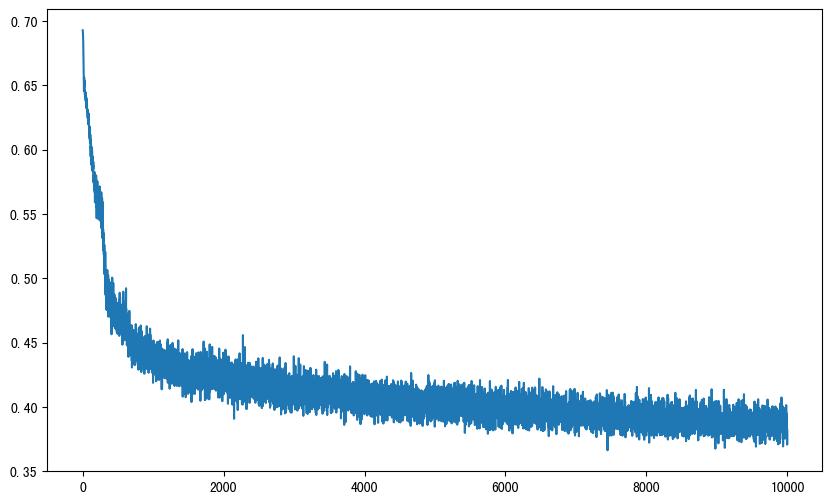

In [110]:
plot_loss(ls_loss3[:])